In [1]:
import matplotlib.pyplot as plt
from openpyxl import load_workbook
import numpy as np
from scipy.optimize import curve_fit
import scipy

In [2]:
wb = load_workbook("/Users/kunwoosmac/Library/Mobile Documents/com~apple~CloudDocs/Mac/2023_Fall/MMAE 419/3.Tension/Tension Test_BB_F2023.xlsx")

In [3]:
def line(x, m, n):
    return (m*x + n)

def line_origin(x, m):
    return m*x

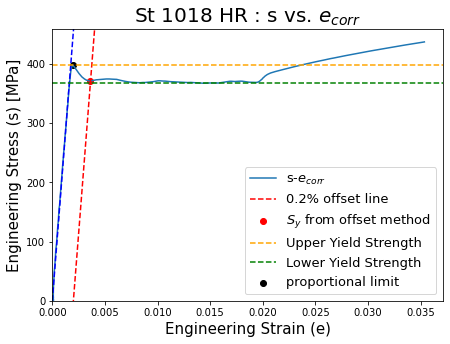

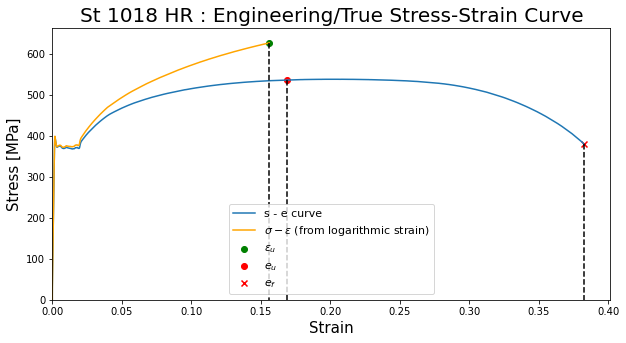

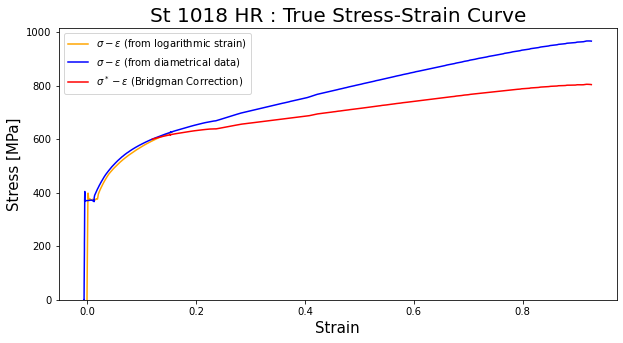

correction (e0 where e -> e-e0) : -0.00010246218858177122
Young's Modulus (E) : 227.513 GPa
Yield Strength From 2% offset method : 371.447 MPa (error : 9.240 MPa)
UYS : 397.581 MPa
LYS : 367.459 MPa
e failure : 0.3822472440944883
true strain failure : 0.9260043041377513
Proportional Limit : 397.581 MPa
UTS : 535.4637748784779 MPa
Uniform Strain : 0.16899291338582678
Toughness : -44.4237396779648 MPa
Resilience : 0.3002136737343683Mpa
n : 0.16315737763925078
K : 849.5289763296895
R^2 : 0.9992539141678181


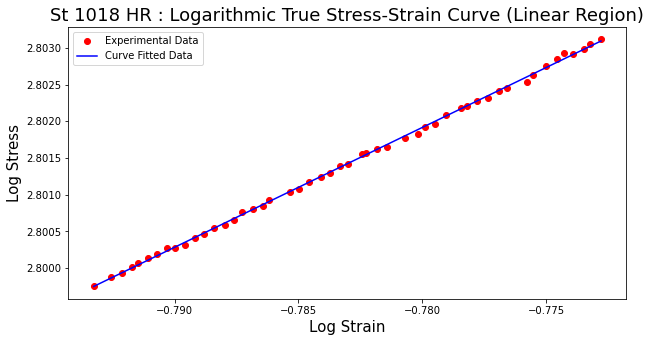

In [75]:
name_ori = '01-St 1018 HR'
name = name_ori.split('-')[1]
fig_path = '/Users/kunwoosmac/Library/Mobile Documents/com~apple~CloudDocs/Mac/2023_Fall/MMAE 419/3.Tension/Figures/'
ws = wb[name_ori]

D = ws.cell(3,4).value # Diameter inch
L0 = ws.cell(6,4).value # length inch

delta = np.array([ws.cell(i,2).value for i in range(11, ws.max_row)]) # inch or mm
load = np.array([ws.cell(i,3).value for i in range(11, ws.max_row)]) # lbf or N

# convert everything to SI units

D = D * 25.4 # mm
A0 = ws.cell(3,6).value # mm^2
L0 = L0 * 25.4 # mm

if ws.cell(10,2).value == '(in)':
    delta = delta * 25.4 # set it to mm
else :
    delta = delta # delta is in mm... setting it to meter causes problem in fitting
    
if ws.cell(10,3).value == '(lbf)':
    load = load * 4.448

stress = load/A0 # N/mm^2 = MPa
strain = delta/L0 # strain

# Get the UYS, LYS
ds = np.gradient(stress) 
    # use gradient & find where it turns from positive -> negative and vice versa

for i in range(len(ds)):
    if ds[i] < 0:
        UYS_idx = i
        break
for i in range(UYS_idx, len(ds)):
    t_list = [i+x for x in list(range(15))]
    temp = np.array([ds[x] for x in t_list])
    if (temp >= 0).all():
        YPE_idx = i
        break

LYS_idx = np.argmin(stress[UYS_idx:YPE_idx]) + UYS_idx

# Doing the offset Method

# Curve fit
# First, make correction for initial non-linearity
cf_strain = strain[0:UYS_idx]
cf_stress = stress[0:UYS_idx]
pars, _ = curve_fit(f = line, xdata = cf_strain, ydata = cf_stress)
e0 = -pars[1]/pars[0]
cor_strain = strain - e0


# Then, do actual curve-fit
cf_strain = cor_strain[0:UYS_idx]
cf_stress = stress[0:UYS_idx]
pars, _ = curve_fit(f = line_origin, xdata = cf_strain, ydata = cf_stress)
E = pars[0] # Mpa
# print(E)


# Plot the corrected engineering e-s and curvefitted line for Young's Modulus
plt.figure(figsize = (7, 5))
plt.title(name + " : s vs. $e_{corr}$", fontsize = 20)
plt.plot(cor_strain[0:ws.max_row//7], stress[0:ws.max_row//7], label = 's-$e_{corr}$')

plt.ylabel("Engineering Stress (s) [MPa]", fontsize = 15)
plt.xlabel("Engineering Strain (e)", fontsize = 15)

plt.xlim(0)
plt.ylim(0)

inf = np.linspace(0,0.00900,10)

plt.plot(inf, line_origin(inf, E), c = 'blue', linestyle = 'dashed')

# Plot 0.2% offset line
plt.plot(inf, line_origin(inf, E) - 0.002*E, c = 'red', linestyle = 'dashed',\
         label = '0.2% offset line')
# Get intersection of offset line & curve
# it is not exact intersect but,
error = np.min(np.absolute(line_origin(cor_strain - 0.002, E) - stress))
min_idx = np.argmin(np.absolute(line_origin(cor_strain - 0.002, E) - stress))
plt.scatter(cor_strain[min_idx], stress[min_idx], c = 'red',\
            label = '$S_y$ from offset method')


# Plot UYS, LYS
plt.axhline(stress[UYS_idx], linestyle = 'dashed', c = 'orange', \
                    label = "Upper Yield Strength")
plt.axhline(stress[LYS_idx], linestyle = 'dashed', c = 'green', \
                    label = 'Lower Yield Strength')

# Proportional Limit
plt.scatter(cor_strain[UYS_idx], stress[UYS_idx], c = 'black', marker = 'o', label = 'proportional limit')


plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.legend(fontsize = 13)
# plt.grid()

plt.savefig(fig_path + name)

plt.show()

# ==================== # # ==================== # # ==================== # # ==================== # 

# PLOT 2
# Find UTS
for i in range(YPE_idx, len(ds)):
    if ds[i].round(3) == 0:
        UTS_idx = i
        break

name_D = '02-St 1018 HR (D)'
ws = wb[name_D]

load = np.array([ws.cell(i,1).value for i in range(9,ws.max_row)]) # N
diameter = np.array([ws.cell(i,2).value for i in range(9,ws.max_row)]) # mm

area = np.pi/4 * diameter ** 2 # Neck Area
strain_2 = np.log(A0/area)
stress_2 = load/area

plt.figure(figsize = (10, 5))
plt.title(name + " : Engineering/True Stress-Strain Curve", fontsize = 20)

# s-e curve
plt.plot(strain, stress, label = "s - e curve")

epsilon = np.log(1+strain[:UTS_idx])
sigma = stress[:UTS_idx]*(1+strain[:UTS_idx])

# True stress strain curv
plt.plot(epsilon, sigma, label = '$\sigma - \epsilon$ (from logarithmic strain)'\
         , c = 'orange')
plt.plot([epsilon[-1],epsilon[-1]], [sigma[-1], -100], c = 'black', linestyle = 'dashed')

# epsilon_ultimate
plt.scatter(epsilon[-1], sigma[-1], c = 'green', marker = 'o', label = '$\epsilon_u$')

# e_ultimate
plt.scatter(strain[UTS_idx], stress[UTS_idx], c = 'red', \
                    label = "$e_u$")
plt.plot([strain[i],strain[i]], [stress[i], -100], c = 'black', linestyle = 'dashed')
        
# e_failure
plt.scatter(strain[-1], stress[-1], label = '$e_f$', marker = 'x', c = 'r')
plt.plot([strain[-1],strain[-1]], [stress[-1], -100], c = 'black', linestyle = 'dashed')
ef = strain[-1]

# Resilience
PL = UYS_idx
res = scipy.integrate.simps(strain[:PL],stress[:PL])
tough = scipy.integrate.simps(strain,stress)

# Settings
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.legend(loc = 'lower center', fontsize = 11)

plt.ylabel("Stress [MPa]", fontsize = 15)
plt.xlabel("Strain", fontsize = 15)

plt.xlim(0)
plt.ylim(0)

plt.savefig(fig_path + name + "_True")
plt.show()


# ==================== # # ==================== # # ==================== # # ==================== # 

plt.figure(figsize = (10, 5))
plt.title(name + " : True Stress-Strain Curve", fontsize = 20)

plt.plot(epsilon, sigma, label = '$\sigma - \epsilon$ (from logarithmic strain)', c = 'orange')

plt.plot(strain_2, stress_2, label = "$\sigma-\epsilon$ (from diametrical data)", c = 'blue')

# Bridgman correction
# find the spot where bridgman correction begins
diff = strain_2 - 0.12
b_idx = np.argmin(np.abs(diff))

x = np.log10(strain_2[b_idx:])
B = 0.0684*x**3  + 0.0461*x**2  - 0.205*x + 0.825

stress_corr = np.multiply(B, stress_2[b_idx:])

plt.plot(strain_2[b_idx:], stress_corr, label = "$\sigma^*-\epsilon$ (Bridgman Correction)", c = 'red')

# Settings
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.legend(loc = 'lower center', fontsize = 11)

plt.ylabel("Stress [MPa]", fontsize = 15)
plt.xlabel("Strain", fontsize = 15)

plt.ylim(0)
plt.legend()
plt.savefig(fig_path + name + "_Diameter")

plt.show()


# Power Law
# Find the UTS for the diameter thing (its different for some reason)
diff = strain_2 - strain[UTS_idx]
UTS_idx2 = np.argmin(np.abs(diff))
# plt.scatter(strain_2[UTS_idx2],stress_2[UTS_idx2])

plt.figure(figsize = (10, 5))
plt.title(name + " : Logarithmic True Stress-Strain Curve (Linear Region)", fontsize = 18)

log_strain = np.log10(strain_2[UTS_idx2-50:UTS_idx2])
log_stress = np.log10(stress_2[UTS_idx2-50:UTS_idx2])
plt.scatter(log_strain, log_stress, c = 'r', label = 'Experimental Data')

pars, _ = curve_fit(f = line, xdata = log_strain, ydata = log_stress)
plt.plot(log_strain, line(log_strain, pars[0], pars[1]), c = 'b', label = 'Curve Fitted Data')

residuals = log_stress- line(log_strain, *pars)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((log_stress-np.mean(log_stress))**2)
r_squared = 1 - (ss_res / ss_tot)
print("R^2 : {}".format(r_squared))

plt.ylabel("Log Stress", fontsize = 15)
plt.xlabel("Log Strain", fontsize = 15)

plt.legend()
plt.savefig(fig_path + name + "_Power Law")


n = pars[0]
K = 10**pars[1]

print("correction (e0 where e -> e-e0) :", e0)
print("Young's Modulus (E) : {:.3f} GPa".format(E / 1000))
print("Yield Strength From 2% offset method : {:.3f} MPa (error : {:.3f} MPa)".format(stress[min_idx], error))      
print("UYS : {:.3f} MPa\nLYS : {:.3f} MPa".format(stress[UYS_idx], stress[LYS_idx]))
print("e failure : {}\ntrue strain failure : {}".format(ef, strain_2[-1]))
print("Proportional Limit : {:.3f} MPa".format(stress[UYS_idx]))
print("UTS : {} MPa\nUniform Strain : {}".format(stress[UTS_idx], strain[UTS_idx]))
print("Toughness : {} MPa\nResilience : {}Mpa".format(tough, res))
print("n : {}\nK : {}".format(n, K))
print("R^2 : {}".format(r_squared))

Displacement Converted!
Load Converted!
!


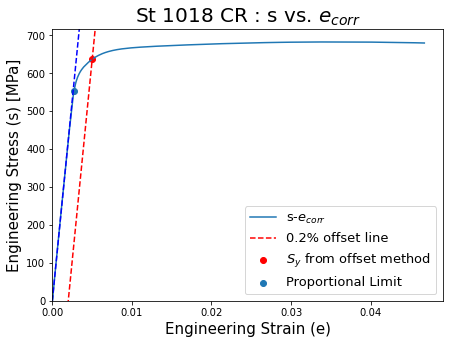

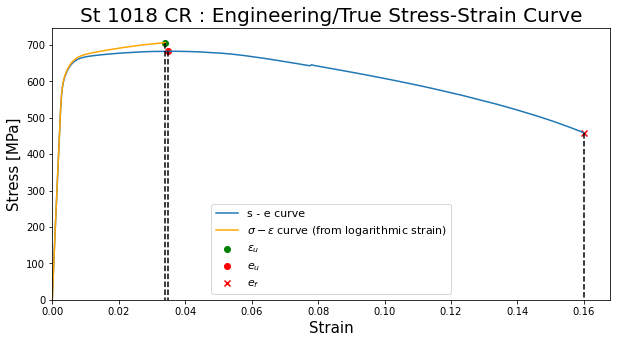

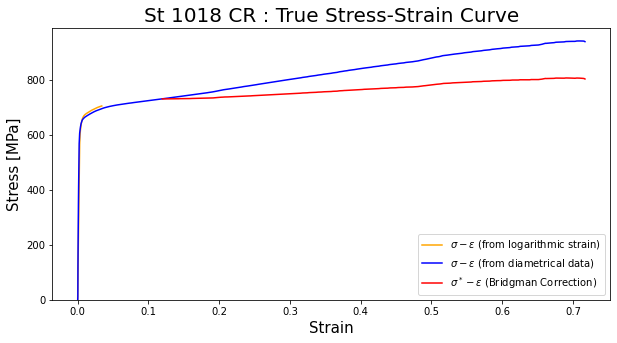

R^2 : 0.9988789620390738
correction (e0 where e -> e-e0) : -2.6722927005203566e-05
Young's Modulus (E) : 211.598 GPa
Yield Strength From 2% offset method : 637.261 MPa (error : 2.131 MPa)
Proportional Limit : 552.651
UTS : 682.7655907378171 MPa
Uniform Strain : 0.034735
e failure : 0.15995
true strain failure : 0.7170828736450595
Toughness : -24.106352595688374 MPa
Resilience : 0.6981300828142845Mpa
n : 0.04185311673687915
K : 802.619388901336


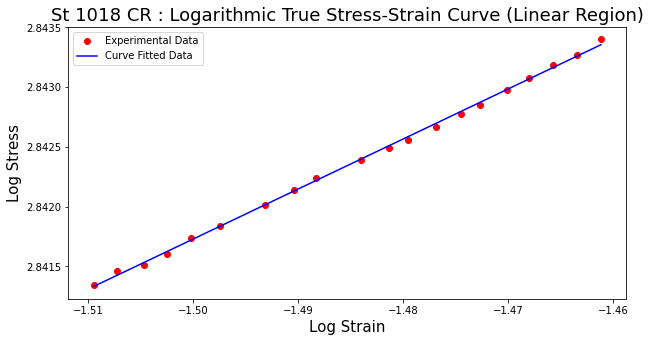

In [76]:
name_ori = '03-St 1018 CR'
name = name_ori.split('-')[1]
ws = wb[name_ori]

D = ws.cell(3,4).value # Diameter inch
L0 = ws.cell(6,4).value # length inch

delta = np.array([ws.cell(i,2).value for i in range(11, ws.max_row)]) # inch or mm
load = np.array([ws.cell(i,3).value for i in range(11, ws.max_row)]) # lbf or N

# convert everything to SI units

D = D * 25.4 # mm
A0 = ws.cell(3,6).value # mm^2
L0 = L0 * 25.4 # mm

if ws.cell(10,2).value == '(in)':
    delta = delta * 25.4 # set it to mm
    print("Displacement Converted!")
else :
    delta = delta # delta is in mm... setting it to meter causes problem in fitting
    
if ws.cell(10,3).value == '(lbf)':
    load = load * 4.448
    print("Load Converted!")

stress = load/A0 # N/mm^2 = MPa
strain = delta/L0 # strain

# Find the linear region
n = 7
# plt.plot(strain[:ws.max_row//n], stress[:ws.max_row//n])
linear_region = ws.max_row//n

# Doing the offset Method

# Curve fit
# First, make correction for initial non-linearity
cf_strain = strain[0:linear_region]
cf_stress = stress[0:linear_region]
pars, _ = curve_fit(f = line, xdata = cf_strain, ydata = cf_stress)
e0 = -pars[1]/pars[0]
m = pars[0]; n =pars[1]
cor_strain = strain - e0


# Then, do actual curve-fit
cf_strain = cor_strain[0:linear_region]
cf_stress = stress[0:linear_region]
pars, _ = curve_fit(f = line_origin, xdata = cf_strain, ydata = cf_stress)
E = pars[0] # Mpa


# Plot the corrected engineering e-s and curvefitted line for Young's Modulus
plt.figure(figsize = (7, 5))
plt.title(name + " : s vs. $e_{corr}$", fontsize = 20)
plt.plot(cor_strain[0:ws.max_row//2], stress[0:ws.max_row//2], label = 's-$e_{corr}$')

plt.ylabel("Engineering Stress (s) [MPa]", fontsize = 15)
plt.xlabel("Engineering Strain (e)", fontsize = 15)

plt.xlim(0)
plt.ylim(0)

inf = np.linspace(0,0.02,10)

plt.plot(inf, line_origin(inf, E), c = 'blue', linestyle = 'dashed')

# Plot 0.2% offset line
plt.plot(inf, line_origin(inf, E) - 0.002*E, c = 'red', linestyle = 'dashed',\
         label = '0.2% offset line')
# Get intersection of offset line & curve
# it is not exact intersect but,
error = np.min(np.absolute(line_origin(cor_strain - 0.002, E) - stress))
min_idx = np.argmin(np.absolute(line_origin(cor_strain - 0.002, E) - stress))
plt.scatter(cor_strain[min_idx], stress[min_idx], c = 'red',\
            label = '$S_y$ from offset method')

# Proportional Limit
eps = 0.00015
for sss, eee in zip(np.flip(stress), np.flip(cor_strain)):
    if np.abs((sss-n)/m - eee) <= eps:
        print('!')
        PL = sss
        PL_strain = eee
        break

PL_idx = np.where(stress == PL)[0][0]
# Resilience & Toughness
res = scipy.integrate.simps(strain[:PL_idx],stress[:PL_idx])
tough = scipy.integrate.simps(strain,stress)

plt.scatter(PL_strain, PL, label = 'Proportional Limit')


plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.legend(fontsize = 13)

plt.savefig(fig_path + name)

plt.show()

# ==================== # # ==================== # # ==================== # # ==================== # 

# PLOT 2
# Find UTS
UTS_idx = np.argmax(stress)

name_D = '04-St 1018 CR (D)'
ws = wb[name_D]

load = np.array([ws.cell(i,1).value for i in range(9,1177)]) # N
diameter = np.array([ws.cell(i,2).value for i in range(9,1177)]) # mm

area = np.pi/4 * diameter ** 2 # Neck Area
strain_2 = np.log(A0/area)
stress_2 = load/area

plt.figure(figsize = (10, 5))
plt.title(name + " : Engineering/True Stress-Strain Curve", fontsize = 20)

# s-e curve
plt.plot(strain, stress, label = "s - e curve")

epsilon = np.log(1+strain[:UTS_idx])
sigma = stress[:UTS_idx]*(1+strain[:UTS_idx])

# True stress strain curv
plt.plot(epsilon, sigma, label = '$\sigma - \epsilon$ curve (from logarithmic strain)'\
         , c = 'orange')
plt.plot([epsilon[-1],epsilon[-1]], [sigma[-1], -100], c = 'black', linestyle = 'dashed')



# epsilon_ultimate
plt.scatter(epsilon[-1], sigma[-1], c = 'green', marker = 'o', label = '$\epsilon_u$')

# e_ultimate
plt.scatter(strain[UTS_idx], stress[UTS_idx], c = 'red', \
                    label = "$e_u$")
plt.plot([strain[UTS_idx],strain[UTS_idx]], [stress[UTS_idx], -100], c = 'black', linestyle = 'dashed')
        
# e_failure
plt.scatter(strain[-1], stress[-1], label = '$e_f$', marker = 'x', c = 'r')
plt.plot([strain[-1],strain[-1]], [stress[-1], -100], c = 'black', linestyle = 'dashed')
ef = strain[-1]

# Settings
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.legend(loc = 'lower center', fontsize = 11)

plt.ylabel("Stress [MPa]", fontsize = 15)
plt.xlabel("Strain", fontsize = 15)

plt.xlim(0)
plt.ylim(0)

plt.savefig(fig_path + name + "_2")

plt.show()

# ==================== # # ==================== # # ==================== # # ==================== # 

plt.figure(figsize = (10, 5))
plt.title(name + " : True Stress-Strain Curve", fontsize = 20)

plt.plot(epsilon, sigma, label = '$\sigma - \epsilon$ (from logarithmic strain)', c = 'orange')

plt.plot(strain_2, stress_2, label = "$\sigma-\epsilon$ (from diametrical data)", c = 'blue')

# Bridgman correction
# find the spot where bridgman correction begins
diff = strain_2 - 0.12
b_idx = np.argmin(np.abs(diff))

x = np.log10(strain_2[b_idx:])
B = 0.0684*x**3  + 0.0461*x**2  - 0.205*x + 0.825

stress_corr = np.multiply(B, stress_2[b_idx:])

plt.plot(strain_2[b_idx:], stress_corr, label = "$\sigma^*-\epsilon$ (Bridgman Correction)", c = 'red')

# Settings
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.legend(loc = 'lower center', fontsize = 11)

plt.ylabel("Stress [MPa]", fontsize = 15)
plt.xlabel("Strain", fontsize = 15)

plt.ylim(0)
plt.legend()
plt.savefig(fig_path + name + "_Diameter")

plt.show()


# Power Law
# Find the UTS for the diameter thing (its different for some reason)
diff = strain_2 - strain[UTS_idx]
UTS_idx2 = np.argmin(np.abs(diff))
# plt.scatter(strain_2[UTS_idx2],stress_2[UTS_idx2])

plt.figure(figsize = (10, 5))
plt.title(name + " : Logarithmic True Stress-Strain Curve (Linear Region)", fontsize = 18)
plt.ylabel("Log Stress", fontsize = 15)
plt.xlabel("Log Strain", fontsize = 15)

log_strain = np.log10(strain_2[UTS_idx2-20:UTS_idx2])
log_stress = np.log10(stress_2[UTS_idx2-20:UTS_idx2])
plt.scatter(log_strain, log_stress, c = 'r', label = 'Experimental Data')

pars, _ = curve_fit(f = line, xdata = log_strain, ydata = log_stress)
plt.plot(log_strain, line(log_strain, pars[0], pars[1]), c = 'b', label = 'Curve Fitted Data')

n = pars[0]
K = 10**pars[1]

residuals = log_stress- line(log_strain, *pars)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((log_stress-np.mean(log_stress))**2)
r_squared = 1 - (ss_res / ss_tot)
print("R^2 : {}".format(r_squared))

plt.legend()
plt.savefig(fig_path + name + "_Power Law")

print("correction (e0 where e -> e-e0) :", e0)
print("Young's Modulus (E) : {:.3f} GPa".format(E / 1000))
print("Yield Strength From 2% offset method : {:.3f} MPa (error : {:.3f} MPa)".format(stress[min_idx], error))
print("Proportional Limit : {:.3f}".format(PL))
print("UTS : {} MPa\nUniform Strain : {}".format(stress[UTS_idx], strain[UTS_idx]))
print("e failure : {}\ntrue strain failure : {}".format(ef, strain_2[-1]))
print("Toughness : {} MPa\nResilience : {}Mpa".format(tough, res))
print("n : {}\nK : {}".format(n, K))

Displacement Converted!
Load Converted!
!


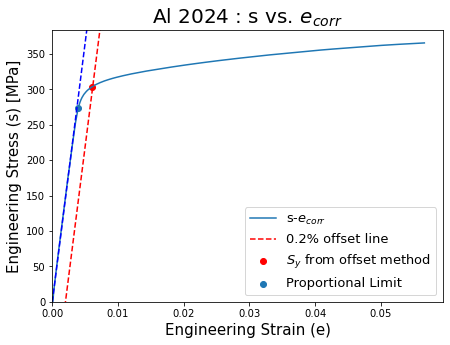

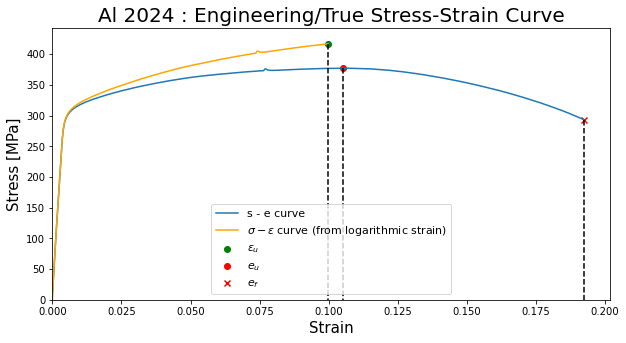

correction (e0 where e -> e-e0) : -7.824922131518129e-05
Young's Modulus (E) : 73.238 GPa
Yield Strength From 2% offset method : 304.048 MPa (error : 3.900 MPa)
Proportional Limit : 274.219
UTS : 377.3810204792756 MPa
Uniform Strain : 0.105285
e failure : 0.19229
Toughness : -10.652742822325159 MPa
Resilience : 0.48377028908589464Mpa


In [48]:
name_ori = '05-Al 2024'
name = name_ori.split('-')[1]
ws = wb[name_ori]

D = ws.cell(3,4).value # Diameter inch
L0 = ws.cell(6,4).value # length inch

delta = np.array([ws.cell(i,2).value for i in range(11, ws.max_row)]) # inch or mm
load = np.array([ws.cell(i,3).value for i in range(11, ws.max_row)]) # lbf or N

# convert everything to SI units

D = D * 25.4 # mm
A0 = ws.cell(3,6).value # mm^2
L0 = L0 * 25.4 # mm

if ws.cell(10,2).value == '(in)':
    delta = delta * 25.4 # set it to mm
    print("Displacement Converted!")
else :
    delta = delta # delta is in mm... setting it to meter causes problem in fitting
    
if ws.cell(10,3).value == '(lbf)':
    load = load * 4.448
    print("Load Converted!")

stress = load/A0 # N/mm^2 = MPa
strain = delta/L0 # strain

# Find the linear region
n = 9
# plt.plot(strain[:ws.max_row//n], stress[:ws.max_row//n])
linear_region = ws.max_row//n
# plt.plot(strain[:linear_region], stress[:linear_region])

# Doing the offset Method


# Curve fit
# First, make correction for initial non-linearity
cf_strain = strain[0:linear_region]
cf_stress = stress[0:linear_region]
pars, _ = curve_fit(f = line, xdata = cf_strain, ydata = cf_stress)
e0 = -pars[1]/pars[0]
m = pars[0]; n =pars[1]
cor_strain = strain - e0


# Then, do actual curve-fit
cf_strain = cor_strain[0:linear_region]
cf_stress = stress[0:linear_region]
pars, _ = curve_fit(f = line_origin, xdata = cf_strain, ydata = cf_stress)
E = pars[0] # Mpa


# Plot the corrected engineering e-s and curvefitted line for Young's Modulus
plt.figure(figsize = (7, 5))
plt.title(name + " : s vs. $e_{corr}$", fontsize = 20)
plt.plot(cor_strain[0:ws.max_row//2], stress[0:ws.max_row//2], label = 's-$e_{corr}$')

plt.ylabel("Engineering Stress (s) [MPa]", fontsize = 15)
plt.xlabel("Engineering Strain (e)", fontsize = 15)

plt.xlim(0)
plt.ylim(0)

inf = np.linspace(0,0.02,10)

plt.plot(inf, line_origin(inf, E), c = 'blue', linestyle = 'dashed')

# Plot 0.2% offset line
plt.plot(inf, line_origin(inf, E) - 0.002*E, c = 'red', linestyle = 'dashed',\
         label = '0.2% offset line')
# Get intersection of offset line & curve
# it is not exact intersect but,
error = np.min(np.absolute(line_origin(cor_strain - 0.002, E) - stress))
min_idx = np.argmin(np.absolute(line_origin(cor_strain - 0.002, E) - stress))
plt.scatter(cor_strain[min_idx], stress[min_idx], c = 'red',\
            label = '$S_y$ from offset method')

# Proportional Limit
eps = 0.0003
for sss, eee in zip(np.flip(stress), np.flip(cor_strain)):
    if np.abs((sss-n)/m - eee) <= eps:
        print("!")
        PL = sss
        PL_strain = eee
        break

PL_idx = np.where(stress == PL)[0][0]
plt.scatter(PL_strain, PL, label = 'Proportional Limit')

# Resilience & Toughness
res = scipy.integrate.simps(strain[:PL_idx],stress[:PL_idx])
tough = scipy.integrate.simps(strain,stress)


plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.legend(fontsize = 13)

plt.savefig(fig_path + name)

plt.show()

# ==================== # # ==================== # # ==================== # # ==================== # 

# PLOT 2
# Find UTS
UTS_idx = np.argmax(stress)

plt.figure(figsize = (10, 5))
plt.title(name + " : Engineering/True Stress-Strain Curve", fontsize = 20)

# s-e curve
plt.plot(strain, stress, label = "s - e curve")

epsilon = np.log(1+strain[:UTS_idx])
sigma = stress[:UTS_idx]*(1+strain[:UTS_idx])

# True stress strain curv
plt.plot(epsilon, sigma, label = '$\sigma - \epsilon$ curve (from logarithmic strain)'\
         , c = 'orange')
plt.plot([epsilon[-1],epsilon[-1]], [sigma[-1], -100], c = 'black', linestyle = 'dashed')



# epsilon_ultimate
plt.scatter(epsilon[-1], sigma[-1], c = 'green', marker = 'o', label = '$\epsilon_u$')

# e_ultimate
plt.scatter(strain[UTS_idx], stress[UTS_idx], c = 'red', \
                    label = "$e_u$")
plt.plot([strain[UTS_idx],strain[UTS_idx]], [stress[UTS_idx], -100], c = 'black', linestyle = 'dashed')
        
# e_failure
plt.scatter(strain[-1], stress[-1], label = '$e_f$', marker = 'x', c = 'r')
plt.plot([strain[-1],strain[-1]], [stress[-1], -100], c = 'black', linestyle = 'dashed')
ef = strain[-1]

# Settings
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.legend(loc = 'lower center', fontsize = 11)

plt.ylabel("Stress [MPa]", fontsize = 15)
plt.xlabel("Strain", fontsize = 15)

plt.xlim(0)
plt.ylim(0)

plt.savefig(fig_path + name + "_2")

plt.show()

print("correction (e0 where e -> e-e0) :", e0)
print("Young's Modulus (E) : {:.3f} GPa".format(E / 1000))
print("Yield Strength From 2% offset method : {:.3f} MPa (error : {:.3f} MPa)".format(stress[min_idx], error))
print("Proportional Limit : {:.3f}".format(PL))
print("UTS : {} MPa\nUniform Strain : {}".format(stress[UTS_idx], strain[UTS_idx]))
print("e failure : {}".format(ef))
print("Toughness : {} MPa\nResilience : {}Mpa".format(tough, res))

Displacement Converted!
Load Converted!
!


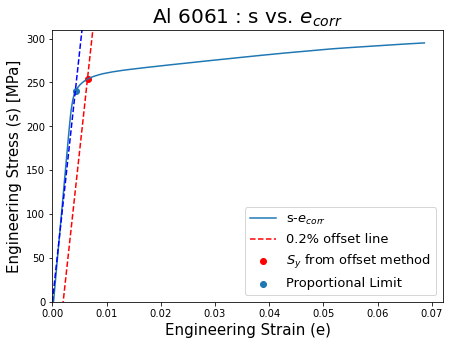

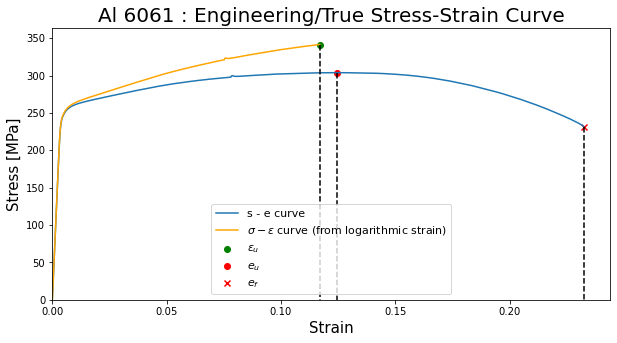

correction (e0 where e -> e-e0) : -0.00021634968933471944
Young's Modulus (E) : 56.620 GPa
Yield Strength From 2% offset method : 253.777 MPa (error : 1.087 MPa)
Proportional Limit : 240.181
UTS : 303.82620883876217 MPa
Uniform Strain : 0.12442
e failure : 0.23242
Toughness : -12.01692016731632 MPa
Resilience : 0.42287084745487Mpa


In [49]:
name_ori = '06-Al 6061'
name = name_ori.split('-')[1]
ws = wb[name_ori]

D = ws.cell(3,4).value # Diameter inch
L0 = ws.cell(6,4).value # length inch

delta = np.array([ws.cell(i,2).value for i in range(11, ws.max_row)]) # inch or mm
load = np.array([ws.cell(i,3).value for i in range(11, ws.max_row)]) # lbf or N

# convert everything to SI units

D = D * 25.4 # mm
A0 = ws.cell(3,6).value # mm^2
L0 = L0 * 25.4 # mm

if ws.cell(10,2).value == '(in)':
    delta = delta * 25.4 # set it to mm
    print("Displacement Converted!")
else :
    delta = delta # delta is in mm... setting it to meter causes problem in fitting
    
if ws.cell(10,3).value == '(lbf)':
    load = load * 4.448
    print("Load Converted!")

stress = load/A0 # N/mm^2 = MPa
strain = delta/L0 # strain

# Find the linear region
n = 9
# plt.plot(strain[:ws.max_row//n], stress[:ws.max_row//n])
linear_region = ws.max_row//n
# plt.plot(strain[:linear_region], stress[:linear_region])

# Doing the offset Method


# Curve fit
# First, make correction for initial non-linearity
cf_strain = strain[0:linear_region]
cf_stress = stress[0:linear_region]
pars, _ = curve_fit(f = line, xdata = cf_strain, ydata = cf_stress)
e0 = -pars[1]/pars[0]
m = pars[0]; n =pars[1]
cor_strain = strain - e0


# Then, do actual curve-fit
cf_strain = cor_strain[0:linear_region]
cf_stress = stress[0:linear_region]
pars, _ = curve_fit(f = line_origin, xdata = cf_strain, ydata = cf_stress)
E = pars[0] # Mpa


# Plot the corrected engineering e-s and curvefitted line for Young's Modulus
plt.figure(figsize = (7, 5))
plt.title(name + " : s vs. $e_{corr}$", fontsize = 20)
plt.plot(cor_strain[0:ws.max_row//2], stress[0:ws.max_row//2], label = 's-$e_{corr}$')

plt.ylabel("Engineering Stress (s) [MPa]", fontsize = 15)
plt.xlabel("Engineering Strain (e)", fontsize = 15)

plt.xlim(0)
plt.ylim(0)

inf = np.linspace(0,0.02,10)

plt.plot(inf, line_origin(inf, E), c = 'blue', linestyle = 'dashed')

# Plot 0.2% offset line
plt.plot(inf, line_origin(inf, E) - 0.002*E, c = 'red', linestyle = 'dashed',\
         label = '0.2% offset line')
# Get intersection of offset line & curve
# it is not exact intersect but,
error = np.min(np.absolute(line_origin(cor_strain - 0.002, E) - stress))
min_idx = np.argmin(np.absolute(line_origin(cor_strain - 0.002, E) - stress))
plt.scatter(cor_strain[min_idx], stress[min_idx], c = 'red',\
            label = '$S_y$ from offset method')

# Proportional Limit
eps = 0.0003
for sss, eee in zip(np.flip(stress), np.flip(cor_strain)):
    if np.abs((sss-n)/m - eee) <= eps:
        print("!")
        PL = sss
        PL_strain = eee
        break

PL_idx = np.where(stress == PL)[0][0]
plt.scatter(PL_strain, PL, label = 'Proportional Limit')

# Resilience & Toughness
res = scipy.integrate.simps(strain[:PL_idx],stress[:PL_idx])
tough = scipy.integrate.simps(strain,stress)


plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.legend(fontsize = 13)

plt.savefig(fig_path + name)

plt.show()

# ==================== # # ==================== # # ==================== # # ==================== # 

# PLOT 2
# Find UTS
UTS_idx = np.argmax(stress)

plt.figure(figsize = (10, 5))
plt.title(name + " : Engineering/True Stress-Strain Curve", fontsize = 20)

# s-e curve
plt.plot(strain, stress, label = "s - e curve")

epsilon = np.log(1+strain[:UTS_idx])
sigma = stress[:UTS_idx]*(1+strain[:UTS_idx])

# True stress strain curv
plt.plot(epsilon, sigma, label = '$\sigma - \epsilon$ curve (from logarithmic strain)'\
         , c = 'orange')
plt.plot([epsilon[-1],epsilon[-1]], [sigma[-1], -100], c = 'black', linestyle = 'dashed')



# epsilon_ultimate
plt.scatter(epsilon[-1], sigma[-1], c = 'green', marker = 'o', label = '$\epsilon_u$')

# e_ultimate
plt.scatter(strain[UTS_idx], stress[UTS_idx], c = 'red', \
                    label = "$e_u$")
plt.plot([strain[UTS_idx],strain[UTS_idx]], [stress[UTS_idx], -100], c = 'black', linestyle = 'dashed')
        
# e_failure
plt.scatter(strain[-1], stress[-1], label = '$e_f$', marker = 'x', c = 'r')
plt.plot([strain[-1],strain[-1]], [stress[-1], -100], c = 'black', linestyle = 'dashed')
ef = strain[-1]

# Settings
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.legend(loc = 'lower center', fontsize = 11)

plt.ylabel("Stress [MPa]", fontsize = 15)
plt.xlabel("Strain", fontsize = 15)

plt.xlim(0)
plt.ylim(0)

plt.savefig(fig_path + name + "_2")

plt.show()

print("correction (e0 where e -> e-e0) :", e0)
print("Young's Modulus (E) : {:.3f} GPa".format(E / 1000))
print("Yield Strength From 2% offset method : {:.3f} MPa (error : {:.3f} MPa)".format(stress[min_idx], error))
print("Proportional Limit : {:.3f}".format(PL))
print("UTS : {} MPa\nUniform Strain : {}".format(stress[UTS_idx], strain[UTS_idx]))
print("e failure : {}".format(ef))
print("Toughness : {} MPa\nResilience : {}Mpa".format(tough, res))

Displacement Converted!
Load Converted!
!


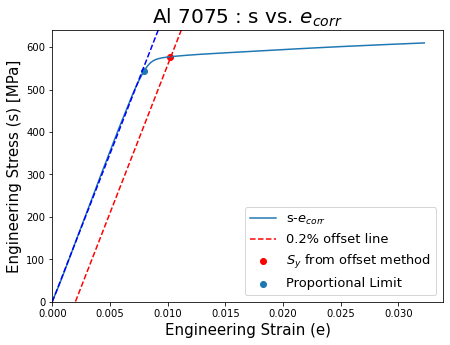

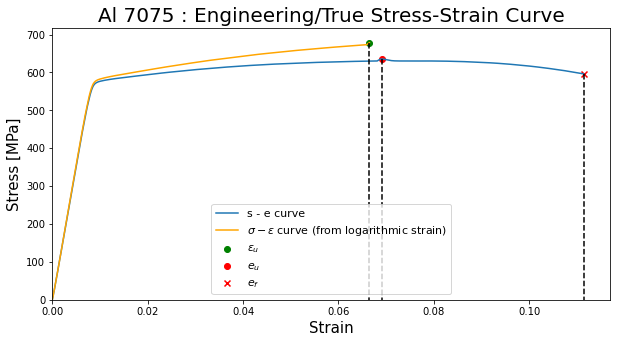

correction (e0 where e -> e-e0) : 2.586502023540639e-05
Young's Modulus (E) : 69.737 GPa
Yield Strength From 2% offset method : 577.270 MPa (error : 4.092 MPa)
Proportional Limit : 544.441
UTS : 635.3093789875628 MPa
Uniform Strain : 0.069105
e failure : 0.111445
Toughness : 0.5023003046567961 MPa
Resilience : 2.0978365094539884Mpa


In [50]:
name_ori = '07-Al 7075'
name = name_ori.split('-')[1]
ws = wb[name_ori]

D = ws.cell(3,4).value # Diameter inch
L0 = ws.cell(6,4).value # length inch

delta = np.array([ws.cell(i,2).value for i in range(11, ws.max_row)]) # inch or mm
load = np.array([ws.cell(i,3).value for i in range(11, ws.max_row)]) # lbf or N

# convert everything to SI units

D = D * 25.4 # mm
A0 = ws.cell(3,6).value # mm^2
L0 = L0 * 25.4 # mm

if ws.cell(10,2).value == '(in)':
    delta = delta * 25.4 # set it to mm
    print("Displacement Converted!")
else :
    delta = delta # delta is in mm... setting it to meter causes problem in fitting
    
if ws.cell(10,3).value == '(lbf)':
    load = load * 4.448
    print("Load Converted!")

stress = load/A0 # N/mm^2 = MPa
strain = delta/L0 # strain

# Find the linear region
n = 9
# plt.plot(strain[:ws.max_row//n], stress[:ws.max_row//n])
linear_region = ws.max_row//n
# plt.plot(strain[:linear_region], stress[:linear_region])

# Doing the offset Method


# Curve fit
# First, make correction for initial non-linearity
cf_strain = strain[0:linear_region]
cf_stress = stress[0:linear_region]
pars, _ = curve_fit(f = line, xdata = cf_strain, ydata = cf_stress)
e0 = -pars[1]/pars[0]
m = pars[0]; n =pars[1]
cor_strain = strain - e0


# Then, do actual curve-fit
cf_strain = cor_strain[0:linear_region]
cf_stress = stress[0:linear_region]
pars, _ = curve_fit(f = line_origin, xdata = cf_strain, ydata = cf_stress)
E = pars[0] # Mpa


# Plot the corrected engineering e-s and curvefitted line for Young's Modulus
plt.figure(figsize = (7, 5))
plt.title(name + " : s vs. $e_{corr}$", fontsize = 20)
plt.plot(cor_strain[0:ws.max_row//2], stress[0:ws.max_row//2], label = 's-$e_{corr}$')

plt.ylabel("Engineering Stress (s) [MPa]", fontsize = 15)
plt.xlabel("Engineering Strain (e)", fontsize = 15)

plt.xlim(0)
plt.ylim(0)

inf = np.linspace(0,0.02,10)

plt.plot(inf, line_origin(inf, E), c = 'blue', linestyle = 'dashed')

# Plot 0.2% offset line
plt.plot(inf, line_origin(inf, E) - 0.002*E, c = 'red', linestyle = 'dashed',\
         label = '0.2% offset line')
# Get intersection of offset line & curve
# it is not exact intersect but,
error = np.min(np.absolute(line_origin(cor_strain - 0.002, E) - stress))
min_idx = np.argmin(np.absolute(line_origin(cor_strain - 0.002, E) - stress))
plt.scatter(cor_strain[min_idx], stress[min_idx], c = 'red',\
            label = '$S_y$ from offset method')

# Proportional Limit
eps = 0.00015
for sss, eee in zip(np.flip(stress), np.flip(cor_strain)):
    if np.abs((sss-n)/m - eee) <= eps:
        print("!")
        PL = sss
        PL_strain = eee
        break

PL_idx = np.where(stress == PL)[0][0]
plt.scatter(PL_strain, PL, label = 'Proportional Limit')

# Resilience & Toughness
res = scipy.integrate.simps(strain[:PL_idx],stress[:PL_idx])
tough = scipy.integrate.simps(strain,stress)


plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.legend(fontsize = 13)

plt.savefig(fig_path + name)

plt.show()

# ==================== # # ==================== # # ==================== # # ==================== # 

# PLOT 2
# Find UTS
UTS_idx = np.argmax(stress)

plt.figure(figsize = (10, 5))
plt.title(name + " : Engineering/True Stress-Strain Curve", fontsize = 20)

# s-e curve
plt.plot(strain, stress, label = "s - e curve")

epsilon = np.log(1+strain[:UTS_idx])
sigma = stress[:UTS_idx]*(1+strain[:UTS_idx])

# True stress strain curv
plt.plot(epsilon, sigma, label = '$\sigma - \epsilon$ curve (from logarithmic strain)'\
         , c = 'orange')
plt.plot([epsilon[-1],epsilon[-1]], [sigma[-1], -100], c = 'black', linestyle = 'dashed')



# epsilon_ultimate
plt.scatter(epsilon[-1], sigma[-1], c = 'green', marker = 'o', label = '$\epsilon_u$')

# e_ultimate
plt.scatter(strain[UTS_idx], stress[UTS_idx], c = 'red', \
                    label = "$e_u$")
plt.plot([strain[UTS_idx],strain[UTS_idx]], [stress[UTS_idx], -100], c = 'black', linestyle = 'dashed')
        
# e_failure
plt.scatter(strain[-1], stress[-1], label = '$e_f$', marker = 'x', c = 'r')
plt.plot([strain[-1],strain[-1]], [stress[-1], -100], c = 'black', linestyle = 'dashed')
ef = strain[-1]

# Settings
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.legend(loc = 'lower center', fontsize = 11)

plt.ylabel("Stress [MPa]", fontsize = 15)
plt.xlabel("Strain", fontsize = 15)

plt.xlim(0)
plt.ylim(0)

plt.savefig(fig_path + name + "_2")

plt.show()

print("correction (e0 where e -> e-e0) :", e0)
print("Young's Modulus (E) : {:.3f} GPa".format(E / 1000))
print("Yield Strength From 2% offset method : {:.3f} MPa (error : {:.3f} MPa)".format(stress[min_idx], error))
print("Proportional Limit : {:.3f}".format(PL))
print("UTS : {} MPa\nUniform Strain : {}".format(stress[UTS_idx], strain[UTS_idx]))
print("e failure : {}".format(ef))
print("Toughness : {} MPa\nResilience : {}Mpa".format(tough, res))

Displacement Converted!
Load Converted!
!


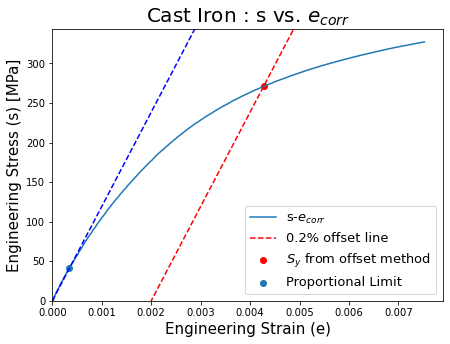

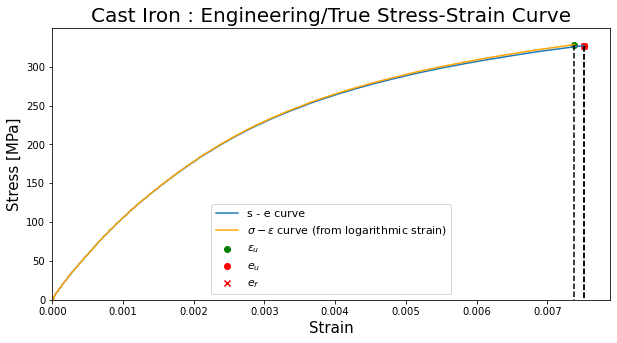

correction (e0 where e -> e-e0) : -9.946383898716902e-06
Young's Modulus (E) : 119.177 GPa
Yield Strength From 2% offset method : 271.278 MPa (error : 1.632 MPa)
Proportional Limit : 41.423
UTS : 327.0814125408952 MPa
Uniform Strain : 0.007515
e failure : 0.007515
Toughness : 0.7499190871445609 MPa
Resilience : 0.005831610797375981Mpa


In [53]:
name_ori = '08-Cast Iron'
name = name_ori.split('-')[1]
ws = wb[name_ori]

D = ws.cell(3,4).value # Diameter inch
L0 = ws.cell(6,4).value # length inch

delta = np.array([ws.cell(i,2).value for i in range(11, ws.max_row)]) # inch or mm
load = np.array([ws.cell(i,3).value for i in range(11, ws.max_row)]) # lbf or N

# convert everything to SI units

D = D * 25.4 # mm
A0 = ws.cell(3,6).value # mm^2
L0 = L0 * 25.4 # mm

if ws.cell(10,2).value == '(in)':
    delta = delta * 25.4 # set it to mm
    print("Displacement Converted!")
else :
    delta = delta # delta is in mm... setting it to meter causes problem in fitting
    
if ws.cell(10,3).value == '(lbf)':
    load = load * 4.448
    print("Load Converted!")

stress = load/A0 # N/mm^2 = MPa
strain = delta/L0 # strain

# Find the linear region
n = 4
# plt.plot(strain[:ws.max_row//n], stress[:ws.max_row//n])
linear_region = ws.max_row//n
# plt.plot(strain[:linear_region], stress[:linear_region])

# Doing the offset Method


# Curve fit
# First, make correction for initial non-linearity
cf_strain = strain[0:linear_region]
cf_stress = stress[0:linear_region]
pars, _ = curve_fit(f = line, xdata = cf_strain, ydata = cf_stress)
e0 = -pars[1]/pars[0]
m = pars[0]; n =pars[1]
cor_strain = strain - e0


# Then, do actual curve-fit
cf_strain = cor_strain[0:linear_region]
cf_stress = stress[0:linear_region]
pars, _ = curve_fit(f = line_origin, xdata = cf_strain, ydata = cf_stress)
E = pars[0] # Mpa


# Plot the corrected engineering e-s and curvefitted line for Young's Modulus
plt.figure(figsize = (7, 5))
plt.title(name + " : s vs. $e_{corr}$", fontsize = 20)
plt.plot(cor_strain[0:ws.max_row], stress[0:ws.max_row], label = 's-$e_{corr}$')

plt.ylabel("Engineering Stress (s) [MPa]", fontsize = 15)
plt.xlabel("Engineering Strain (e)", fontsize = 15)

plt.xlim(0)
plt.ylim(0)

inf = np.linspace(0,0.005,10)

plt.plot(inf, line_origin(inf, E), c = 'blue', linestyle = 'dashed')

# Plot 0.2% offset line
plt.plot(inf, line_origin(inf, E) - 0.002*E, c = 'red', linestyle = 'dashed',\
         label = '0.2% offset line')
# Get intersection of offset line & curve
# it is not exact intersect but,
error = np.min(np.absolute(line_origin(cor_strain - 0.002, E) - stress))
min_idx = np.argmin(np.absolute(line_origin(cor_strain - 0.002, E) - stress))
plt.scatter(cor_strain[min_idx], stress[min_idx], c = 'red',\
            label = '$S_y$ from offset method')

# Proportional Limit
eps = 0.00001
for sss, eee in zip(np.flip(stress), np.flip(cor_strain)):
    if np.abs((sss-n)/m - eee) <= eps:
        print("!")
        PL = sss
        PL_strain = eee
        break

PL_idx = np.where(stress == PL)[0][0]
plt.scatter(PL_strain, PL, label = 'Proportional Limit')

# Resilience & Toughness
res = scipy.integrate.simps(strain[:PL_idx],stress[:PL_idx])
tough = scipy.integrate.simps(strain,stress)


plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.legend(fontsize = 13)

plt.savefig(fig_path + name)

plt.show()

# ==================== # # ==================== # # ==================== # # ==================== # 

# PLOT 2
# Find UTS
UTS_idx = np.argmax(stress)

plt.figure(figsize = (10, 5))
plt.title(name + " : Engineering/True Stress-Strain Curve", fontsize = 20)

# s-e curve
plt.plot(strain, stress, label = "s - e curve")

epsilon = np.log(1+strain[:UTS_idx])
sigma = stress[:UTS_idx]*(1+strain[:UTS_idx])

# True stress strain curv
plt.plot(epsilon, sigma, label = '$\sigma - \epsilon$ curve (from logarithmic strain)'\
         , c = 'orange')
plt.plot([epsilon[-1],epsilon[-1]], [sigma[-1], -100], c = 'black', linestyle = 'dashed')



# epsilon_ultimate
plt.scatter(epsilon[-1], sigma[-1], c = 'green', marker = 'o', label = '$\epsilon_u$')

# e_ultimate
plt.scatter(strain[UTS_idx], stress[UTS_idx], c = 'red', \
                    label = "$e_u$")
plt.plot([strain[UTS_idx],strain[UTS_idx]], [stress[UTS_idx], -100], c = 'black', linestyle = 'dashed')
        
# e_failure
plt.scatter(strain[-1], stress[-1], label = '$e_f$', marker = 'x', c = 'r')
plt.plot([strain[-1],strain[-1]], [stress[-1], -100], c = 'black', linestyle = 'dashed')
ef = strain[-1]

# Settings
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.legend(loc = 'lower center', fontsize = 11)

plt.ylabel("Stress [MPa]", fontsize = 15)
plt.xlabel("Strain", fontsize = 15)

plt.xlim(0)
plt.ylim(0)

plt.savefig(fig_path + name + "_2")

plt.show()

print("correction (e0 where e -> e-e0) :", e0)
print("Young's Modulus (E) : {:.3f} GPa".format(E / 1000))
print("Yield Strength From 2% offset method : {:.3f} MPa (error : {:.3f} MPa)".format(stress[min_idx], error))
print("Proportional Limit : {:.3f}".format(PL))
print("UTS : {} MPa\nUniform Strain : {}".format(stress[UTS_idx], strain[UTS_idx]))
print("e failure : {}".format(ef))
print("Toughness : {} MPa\nResilience : {}Mpa".format(tough, res))

Displacement Converted!
Load Converted!
!


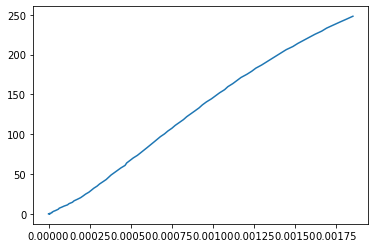

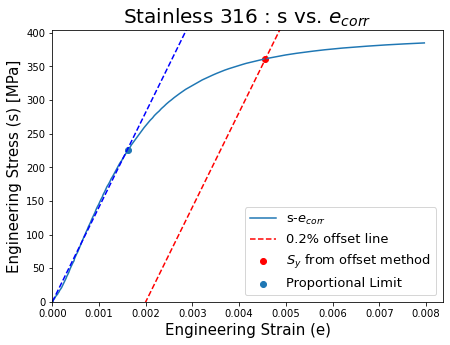

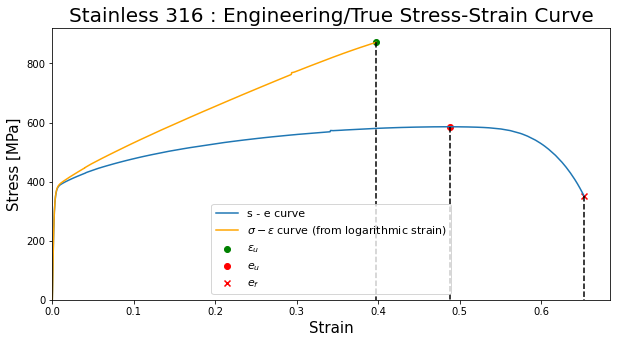

correction (e0 where e -> e-e0) : 2.586502023540639e-05
Young's Modulus (E) : 140.925 GPa
Yield Strength From 2% offset method : 361.386 MPa (error : 1.323 MPa)
Proportional Limit : 225.527
UTS : 585.8190799951564 MPa
Uniform Strain : 0.48815
e failure : 0.652485
Toughness : -114.3765936485441 MPa
Resilience : 0.17349240696495927Mpa


In [51]:
name_ori = '09-Stainless 316'
name = name_ori.split('-')[1]
ws = wb[name_ori]

D = ws.cell(3,4).value # Diameter inch
L0 = ws.cell(6,4).value # length inch

delta = np.array([ws.cell(i,2).value for i in range(11, ws.max_row)]) # inch or mm
load = np.array([ws.cell(i,3).value for i in range(11, ws.max_row)]) # lbf or N

# convert everything to SI units

D = D * 25.4 # mm
A0 = ws.cell(3,6).value # mm^2
L0 = L0 * 25.4 # mm

if ws.cell(10,2).value == '(in)':
    delta = delta * 25.4 # set it to mm
    print("Displacement Converted!")
else :
    delta = delta # delta is in mm... setting it to meter causes problem in fitting
    
if ws.cell(10,3).value == '(lbf)':
    load = load * 4.448
    print("Load Converted!")

stress = load/A0 # N/mm^2 = MPa
strain = delta/L0 # strain

# Find the linear region
n = 35
# plt.plot(strain[:ws.max_row//n], stress[:ws.max_row//n])
linear_region = ws.max_row//n
plt.plot(strain[:linear_region], stress[:linear_region])

# Doing the offset Method


# Curve fit
# # First, make correction for initial non-linearity
# cf_strain = strain[0:linear_region]
# cf_stress = stress[0:linear_region]
# pars, _ = curve_fit(f = line, xdata = cf_strain, ydata = cf_stress)
# e0 = -pars[1]/pars[0]
# m = pars[0]; n =pars[1]
cor_strain = strain


# Then, do actual curve-fit
cf_strain = cor_strain[0:linear_region]
cf_stress = stress[0:linear_region]
pars, _ = curve_fit(f = line_origin, xdata = cf_strain, ydata = cf_stress)
E = pars[0] # Mpa


# Plot the corrected engineering e-s and curvefitted line for Young's Modulus
plt.figure(figsize = (7, 5))
plt.title(name + " : s vs. $e_{corr}$", fontsize = 20)
plt.plot(cor_strain[0:ws.max_row//20], stress[0:ws.max_row//20], label = 's-$e_{corr}$')

plt.ylabel("Engineering Stress (s) [MPa]", fontsize = 15)
plt.xlabel("Engineering Strain (e)", fontsize = 15)

plt.xlim(0)
plt.ylim(0)

inf = np.linspace(0,0.02,10)

plt.plot(inf, line_origin(inf, E), c = 'blue', linestyle = 'dashed')

# Plot 0.2% offset line
plt.plot(inf, line_origin(inf, E) - 0.002*E, c = 'red', linestyle = 'dashed',\
         label = '0.2% offset line')
# Get intersection of offset line & curve
# it is not exact intersect but,
error = np.min(np.absolute(line_origin(cor_strain - 0.002, E) - stress))
min_idx = np.argmin(np.absolute(line_origin(cor_strain - 0.002, E) - stress))
plt.scatter(cor_strain[min_idx], stress[min_idx], c = 'red',\
            label = '$S_y$ from offset method')

# Proportional Limit
eps = 0.00002
for sss, eee in zip(np.flip(stress), np.flip(cor_strain)):
    if np.abs((sss)/E - eee) <= eps:
        print("!")
        PL = sss
        PL_strain = eee
        break

PL_idx = np.where(stress == PL)[0][0]
plt.scatter(PL_strain, PL, label = 'Proportional Limit')

# Resilience & Toughness
res = scipy.integrate.simps(strain[:PL_idx],stress[:PL_idx])
tough = scipy.integrate.simps(strain,stress)


plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.legend(fontsize = 13)

plt.savefig(fig_path + name)

plt.show()

# ==================== # # ==================== # # ==================== # # ==================== # 

# PLOT 2
# Find UTS
UTS_idx = np.argmax(stress)

plt.figure(figsize = (10, 5))
plt.title(name + " : Engineering/True Stress-Strain Curve", fontsize = 20)

# s-e curve
plt.plot(strain, stress, label = "s - e curve")

epsilon = np.log(1+strain[:UTS_idx])
sigma = stress[:UTS_idx]*(1+strain[:UTS_idx])

# True stress strain curv
plt.plot(epsilon, sigma, label = '$\sigma - \epsilon$ curve (from logarithmic strain)'\
         , c = 'orange')
plt.plot([epsilon[-1],epsilon[-1]], [sigma[-1], -100], c = 'black', linestyle = 'dashed')



# epsilon_ultimate
plt.scatter(epsilon[-1], sigma[-1], c = 'green', marker = 'o', label = '$\epsilon_u$')

# e_ultimate
plt.scatter(strain[UTS_idx], stress[UTS_idx], c = 'red', \
                    label = "$e_u$")
plt.plot([strain[UTS_idx],strain[UTS_idx]], [stress[UTS_idx], -100], c = 'black', linestyle = 'dashed')
        
# e_failure
plt.scatter(strain[-1], stress[-1], label = '$e_f$', marker = 'x', c = 'r')
plt.plot([strain[-1],strain[-1]], [stress[-1], -100], c = 'black', linestyle = 'dashed')
ef = strain[-1]

# Settings
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.legend(loc = 'lower center', fontsize = 11)

plt.ylabel("Stress [MPa]", fontsize = 15)
plt.xlabel("Strain", fontsize = 15)

plt.xlim(0)
plt.ylim(0)

plt.savefig(fig_path + name + "_2")

plt.show()

print("correction (e0 where e -> e-e0) :", e0)
print("Young's Modulus (E) : {:.3f} GPa".format(E / 1000))
print("Yield Strength From 2% offset method : {:.3f} MPa (error : {:.3f} MPa)".format(stress[min_idx], error))
print("Proportional Limit : {:.3f}".format(PL))
print("UTS : {} MPa\nUniform Strain : {}".format(stress[UTS_idx], strain[UTS_idx]))
print("e failure : {}".format(ef))
print("Toughness : {} MPa\nResilience : {}Mpa".format(tough, res))

!


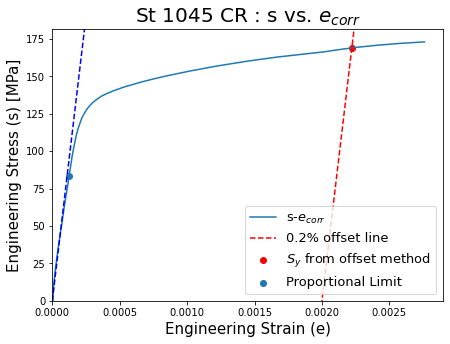

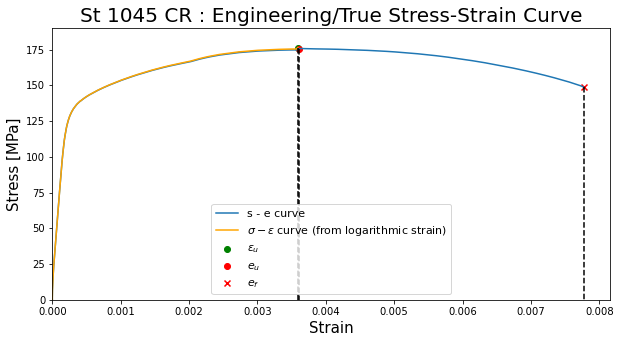

correction (e0 where e -> e-e0) : -5.140149810322031e-06
Young's Modulus (E) : 760.759 GPa
Yield Strength From 2% offset method : 168.988 MPa (error : 0.197 MPa)
Proportional Limit : 83.103
UTS : 175.69717207301164 MPa
Uniform Strain : 0.003610629921259843
e failure : 0.007771259842519686
Toughness : -0.1097316771631018 MPa
Resilience : 0.004123879002690254Mpa


In [52]:
name_ori = '10-St 1045 CR'
name = name_ori.split('-')[1]
ws = wb[name_ori]

D = ws.cell(3,4).value # Diameter inch
L0 = ws.cell(6,4).value # length inch

delta = np.array([ws.cell(i,2).value for i in range(11, ws.max_row)]) # inch or mm
load = np.array([ws.cell(i,3).value for i in range(11, ws.max_row)]) # lbf or N

# convert everything to SI units

D = D * 25.4 # mm
A0 = ws.cell(3,6).value # mm^2
L0 = L0 * 25.4 # mm

if ws.cell(10,2).value == '(in)':
    delta = delta * 25.4 # set it to mm
    print("Displacement Converted!")
else :
    delta = delta # delta is in mm... setting it to meter causes problem in fitting
    
if ws.cell(10,3).value == '(lbf)':
    load = load * 4.448
    print("Load Converted!")

stress = load/A0 # N/mm^2 = MPa
strain = delta/L0 # strain

# Find the linear region
n = 9
# plt.plot(strain[:ws.max_row//n], stress[:ws.max_row//n])
linear_region = ws.max_row//n
# plt.plot(strain[:linear_region], stress[:linear_region])

# Doing the offset Method


# Curve fit
# First, make correction for initial non-linearity
cf_strain = strain[0:linear_region]
cf_stress = stress[0:linear_region]
pars, _ = curve_fit(f = line, xdata = cf_strain, ydata = cf_stress)
e0 = -pars[1]/pars[0]
m = pars[0]; n =pars[1]
cor_strain = strain - e0


# Then, do actual curve-fit
cf_strain = cor_strain[0:linear_region]
cf_stress = stress[0:linear_region]
pars, _ = curve_fit(f = line_origin, xdata = cf_strain, ydata = cf_stress)
E = pars[0] # Mpa


# Plot the corrected engineering e-s and curvefitted line for Young's Modulus
plt.figure(figsize = (7, 5))
plt.title(name + " : s vs. $e_{corr}$", fontsize = 20)
plt.plot(cor_strain[0:ws.max_row//2], stress[0:ws.max_row//2], label = 's-$e_{corr}$')

plt.ylabel("Engineering Stress (s) [MPa]", fontsize = 15)
plt.xlabel("Engineering Strain (e)", fontsize = 15)

plt.xlim(0)
plt.ylim(0)

inf = np.linspace(0,0.02,10)

plt.plot(inf, line_origin(inf, E), c = 'blue', linestyle = 'dashed')

# Plot 0.2% offset line
plt.plot(inf, line_origin(inf, E) - 0.002*E, c = 'red', linestyle = 'dashed',\
         label = '0.2% offset line')
# Get intersection of offset line & curve
# it is not exact intersect but,
error = np.min(np.absolute(line_origin(cor_strain - 0.002, E) - stress))
min_idx = np.argmin(np.absolute(line_origin(cor_strain - 0.002, E) - stress))
plt.scatter(cor_strain[min_idx], stress[min_idx], c = 'red',\
            label = '$S_y$ from offset method')

# Proportional Limit
eps = 0.00002
for sss, eee in zip(np.flip(stress), np.flip(cor_strain)):
    if np.abs((sss-n)/m - eee) <= eps:
        print("!")
        PL = sss
        PL_strain = eee
        break

PL_idx = np.where(stress == PL)[0][0]
plt.scatter(PL_strain, PL, label = 'Proportional Limit')

# Resilience & Toughness
res = scipy.integrate.simps(strain[:PL_idx],stress[:PL_idx])
tough = scipy.integrate.simps(strain,stress)


plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.legend(fontsize = 13)

plt.savefig(fig_path + name)

plt.show()

# ==================== # # ==================== # # ==================== # # ==================== # 

# PLOT 2
# Find UTS
UTS_idx = np.argmax(stress)

plt.figure(figsize = (10, 5))
plt.title(name + " : Engineering/True Stress-Strain Curve", fontsize = 20)

# s-e curve
plt.plot(strain, stress, label = "s - e curve")

epsilon = np.log(1+strain[:UTS_idx])
sigma = stress[:UTS_idx]*(1+strain[:UTS_idx])

# True stress strain curv
plt.plot(epsilon, sigma, label = '$\sigma - \epsilon$ curve (from logarithmic strain)'\
         , c = 'orange')
plt.plot([epsilon[-1],epsilon[-1]], [sigma[-1], -100], c = 'black', linestyle = 'dashed')



# epsilon_ultimate
plt.scatter(epsilon[-1], sigma[-1], c = 'green', marker = 'o', label = '$\epsilon_u$')

# e_ultimate
plt.scatter(strain[UTS_idx], stress[UTS_idx], c = 'red', \
                    label = "$e_u$")
plt.plot([strain[UTS_idx],strain[UTS_idx]], [stress[UTS_idx], -100], c = 'black', linestyle = 'dashed')
        
# e_failure
plt.scatter(strain[-1], stress[-1], label = '$e_f$', marker = 'x', c = 'r')
plt.plot([strain[-1],strain[-1]], [stress[-1], -100], c = 'black', linestyle = 'dashed')
ef = strain[-1]

# Settings
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.legend(loc = 'lower center', fontsize = 11)

plt.ylabel("Stress [MPa]", fontsize = 15)
plt.xlabel("Strain", fontsize = 15)

plt.xlim(0)
plt.ylim(0)

plt.savefig(fig_path + name + "_2")

plt.show()

print("correction (e0 where e -> e-e0) :", e0)
print("Young's Modulus (E) : {:.3f} GPa".format(E / 1000))
print("Yield Strength From 2% offset method : {:.3f} MPa (error : {:.3f} MPa)".format(stress[min_idx], error))
print("Proportional Limit : {:.3f}".format(PL))
print("UTS : {} MPa\nUniform Strain : {}".format(stress[UTS_idx], strain[UTS_idx]))
print("e failure : {}".format(ef))
print("Toughness : {} MPa\nResilience : {}Mpa".format(tough, res))